# Header

Tutorial notebook for coding and training a neural network image classifier from scratch, using numpy only.
Theory and explanations in the [README](../README.md) file.

In [10]:
import sys
import os
import glob

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.colors as colors # for norm=colors.CenteredNorm() in imshow

from PIL import Image
from IPython.display import HTML
from IPython.display import Image as IPImage
from IPython.display import display

# Definitions

In [29]:
# Rectifier linear unit
def ReLU(x):
    return(np.maximum(0,x))

# Derivative of ReLU
def dReLU(x):
    return(np.greater(x, 0).astype(float))

# Softmax normalization
def softmax(x):
    # Subtract max value for numerical stability
    # https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
    x -= np.max(x, axis=0)  
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y

# Corss-entropy loss function
def cross_entropy(y_true_enc, y_pred):
    return -(y_true_enc * np.log(y_pred, where=y_pred > 0)).sum()

# Convert vector y to one-hot-encoded vector with n classes
def one_hot_enc(y, n):
    y_len = len(y)
    y_enc = np.zeros(shape=(n, y_len), dtype=int)
    y_enc[y, np.arange(y_len)] = 1

    return(y_enc)

# Initialize network parameters
def init_params(n_x0_size, n_l1_size, seed):
    rng = np.random.default_rng(seed)
    W1 = rng.normal(size=(n_l1_size, n_x0_size)) / math.sqrt(n_x0_size)
    b1 = np.zeros((n_l1_size, 1))

    W2 = rng.normal(size=(2, n_l1_size)) / math.sqrt(n_l1_size)
    b2 = np.zeros((2, 1))

    return(W1,b1,W2,b2)

# Forward step
# The output is calculated for all input examples in one operation.
# The output is a 2x24 matrix, where each column is a probability distribution 
# for an example to belong to classes {0,1}.
def calc_fwd(x0, W1, b1, W2, b2):
    # @ denotes matrix multiplication, np.matmul

    # W1.shape = 6x9 (row x col)
    # x0.shape = 9x24
    # b1.shape = 6x1
    z1 = W1 @ x0 + b1   # z1.shape = 6x24
    A1 = ReLU(z1)       # A1.shape = 6x24

    # W2.shape = 2x6
    # b2.shape = 2x1
    z2 = W2 @ A1 + b2   # z2.shape = 2x24
    A2 = softmax(z2)    # A2.shape = 2x24

    return(z1, A1, z2, A2)

# Backpropagation
def calc_bck(x0, y_hat, y_enc, z1, A1, W2):

    # logits of all examples in the batch: N_classes x batch_size
    dL_dz2 = (y_hat - y_enc) # dL_dz2.shape = 2x24

    # dL_dz2.shape = 2x24
    # A1.T.shape = 24x6
    dL_dW2 = dL_dz2 @ A1.T # dL_dW2.shape = 2x6

    # sum over the batch/examples; yields a vector for all classes 
    dL_db2 = np.sum(dL_dz2, axis=1, keepdims=True) # dL_db2.shape = 2x1

    # W2.T.shape = 6x2
    # dL_dz2.shape = 2x24
    # (W2.T @ dL_dz2).shape = 6x24
    # z2.shape = 6x24
    # "*" denotes elemnt-wise multiplication
    dL_dz1 = (W2.T @ dL_dz2) * dReLU(z1) # dL_dz1.shape = 6x24

    # dL_dz1.shape = 6x24
    # x0.T.shape = 24x9
    dL_dW1 =  dL_dz1 @ x0.T # dL_dW1.shape = 6x9

    # sum over the batch/examples; yields a vector for all classes
    dL_db1 = np.sum(dL_dz1, axis=1, keepdims = True) # dL_db1.shape = 6x1

    return(dL_dW1, dL_db1, dL_dW2, dL_db2)

# Update paraneters with gradients scaled by the learning rate lr
def update_params(W1, b1, W2, b2, dL_dW1, dL_db1, dL_dW2, dL_db2, lr):
    
    W1 -= lr * dL_dW1 # 6x9
    b1 -= lr * dL_db1 # 6x1
    W2 -= lr * dL_dW2 # 2x6
    b2 -= lr * dL_db2 # 2x1

    return(W1, b1, W2, b2)

# A single forward step
def predict_single(x0,W1,b1,W2,b2):
    _, _, _, y_hat = calc_fwd(np.expand_dims(x0, 1),W1,b1,W2,b2)
    print(y_hat)
    return(np.argmax(y_hat))

def test_pred(x0, y, indx,W1,b1,W2,b2):
    single_ex = x0[:,indx]
    label_pred = predict_single(single_ex,W1,b1,W2,b2)
    label_true = y[indx]
    print("Predicted:", label_pred, "True:", label_true)

# Plot network parameters W and b as heat-maps
def plot_params(W1, b1, W2, b2):
    fig, axs = plt.subplots(
        2, 2, figsize=(12, 6), gridspec_kw={"height_ratios": [2, 1]}
    )


    im = axs[0, 0].imshow(W1, cmap="PuOr_r", vmin=-cmap_vmax, vmax=cmap_vmax)
    axs[0, 1].imshow(b1, cmap="PuOr_r", vmin=-cmap_vmax, vmax=cmap_vmax)
    axs[1, 0].imshow(W2, cmap="PuOr_r", vmin=-cmap_vmax, vmax=cmap_vmax)
    axs[1, 1].imshow(b2, cmap="PuOr_r", vmin=-cmap_vmax, vmax=cmap_vmax)

    axs[0, 0].set_title("$W^{[1]}$")
    axs[0, 1].set_title("$b^{[1]}$")
    axs[1, 0].set_title("$W^{[2]}$")
    axs[1, 1].set_title("$b^{[2]}$")

    axs[0, 1].set_xticks([])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([0, 1])

    axs[0, 0].set_xlabel("9 input pixels")
    axs[0, 0].set_ylabel("6 nodes of the hidden layer")

    axs[1, 0].set_xlabel("6 inputs of the hidden layer")
    axs[1, 0].set_ylabel("2 nodes of the output layer")

    plt.tight_layout()
    add_colorbar(
        im, width=0.015
    )  # add after tight_layout, otherwise not aligned with the plot

    plt.show()

# Save or display the state of the network
def save_fig(x0, W1, b1, z1, 
             A1, W2, b2, y_hat, y, 
             v_xent, v_acc,
             x_max,
             fpath, 
             title, 
             show = False, 
             save = False, 
             plot_vert = False):

    cmap_vmax = calc_vmax(W1, b1, W2, b2)

    fig, axs = plt.subplots(3, 3, figsize=(12, 6), gridspec_kw={'height_ratios': [2, 1, 1]})

    plt.tight_layout()
    
    axs[0,0].imshow(W1, cmap='PuOr_r', vmin = -cmap_vmax, vmax = cmap_vmax)
    axs[0,1].imshow(b1, cmap='PuOr_r', vmin = -cmap_vmax, vmax = cmap_vmax)
    axs[0,2].imshow(A1, cmap='gray', vmin=0)

    axs[1,0].imshow(W2, cmap='PuOr_r', vmin = -cmap_vmax, vmax = cmap_vmax)
    axs[1,1].imshow(b2, cmap='PuOr_r', vmin = -cmap_vmax, vmax = cmap_vmax)
    
    pred_tab = (np.argmax(y_hat, axis = 0) == y)
    color_array = np.where(pred_tab, 1, 2)
    cmap = colors.ListedColormap(['#B4E380', '#FFAAAA'])
    axs[1,2].imshow(y_hat, cmap='gray', vmin=0, vmax=1)
    axs[1,2].scatter(np.arange(len(y)), y, s=10, c = color_array, cmap = cmap)

    axs[2,0].plot(range(v_xent.size), v_xent, label='Cross-Entropy Loss')
    axs[2,0].set_xlim(0, x_max)
    axs[2,0].set_xlabel('Iteration')
    axs[2,0].set_ylabel('Cross-Entropy Loss')
    axs[2,0].set_title('Cross-Entropy Loss vs. Iteration')

    if plot_vert:
        axs[2,0].axvline(x=np.min(np.where(v_acc > MAX_ACC)), color='red', linestyle='--', label='Max accuracy')

    axs[2,0].legend()

    axs[2,1].plot(range(v_acc.size), v_acc, label='Accuracy')
    axs[2,1].set_xlim(0, x_max)
    axs[2,1].set_ylim(0, 1.05)
    axs[2,1].set_yticks([0, .5, 1])
    axs[2,1].set_xlabel('Iteration')
    axs[2,1].set_ylabel('Accuracy')
    axs[2,1].set_title('Accuracy vs. Iteration')

    if plot_vert:
        axs[2,1].axvline(x=np.min(np.where(v_acc > MAX_ACC)), color='red', linestyle='--', label='Max accuracy')

    axs[2,1].legend()

    axs[2, 2].axis('off')

    axs[0,0].set_xticks(np.arange(0,8,3))
    axs[0,0].set_yticks(np.arange(0,6,1))

    axs[0,1].set_xticks([])
    axs[0,1].set_yticks(np.arange(0,6,1))

    axs[0,2].set_xticks(np.arange(0,23,3))
    axs[0,2].set_yticks(np.arange(0,6,2))

    axs[1,0].set_xticks(np.arange(0,6,2))
    axs[1,0].set_yticks([0,1])

    axs[1,1].set_xticks([])
    axs[1,1].set_yticks([0,1])

    axs[1,2].set_xticks(np.arange(0,23,3))
    axs[1,2].set_yticks([0,1])

    axs[0,0].set_title('$W^{[1]}$')
    axs[0,1].set_title('$b^{[1]}$')
    axs[0,2].set_title('$A^{[1]}$')
    axs[1,0].set_title('$W^{[2]}$')
    axs[1,1].set_title('$b^{[2]}$')
    axs[1,2].set_title('$A^{[2]}$; prediction')

    fig.suptitle(title, x = .85, y = .1, fontsize = 16, fontweight = 'bold')

    if (save):
        plt.savefig(fpath, bbox_inches="tight", pad_inches=0.1, dpi=300)

    if (show):
        plt.show()
    else:
        plt.close()

# Calculate accuracy
# based on the true probability distribution y and predicted y_hat.
# Checks the index of the maximum in every column of y_hat and 
# compares against y.
def calc_acc(y, y_hat):
    return (np.argmax(y_hat, axis=0) == y).sum() / len(y)

# Calculate maximum in W and b
# Used to have a common symmetric colorbar for heatmaps
def calc_vmax(W1, b1, W2, b2):
    return np.max([np.max([np.max(W1), np.max(b1),np.max(W2), np.max(b2)]), 
                    np.abs(np.min([np.min(W1), np.min(b1), np.min(W2), np.min(b2)]))])

# Add color bar of the same height as the plot
# From:
# https://stackoverflow.com/a/76378778
def add_colorbar(im, width=None, pad=None, **kwargs):

    l, b, w, h = im.axes.get_position().bounds       # get boundaries
    width = width or 0.1 * w                         # get width of the colorbar
    pad = pad or width                               # get pad between im and cbar
    fig = im.axes.figure                             # get figure of image
    cax = fig.add_axes([l + w + pad, b, width, h])   # define cbar Axes
    return fig.colorbar(im, cax=cax, **kwargs)       # draw cbar

# colour map for classes
cmap_cl = colors.ListedColormap([ '#987D9A','#EECEB9'])
cmap_bin = colors.ListedColormap([ '#000000','#FFFFFF'])

# Threshold for max accuracy
MAX_ACC = 0.999999

# Test if running in Google Colab
# If yes, load data from github
IN_COLAB = 'google.colab' in sys.modules
url_input = "https://raw.githubusercontent.com/dmattek/tutorial-classify-nano/main/data/lines_3x3_train.csv"
url_valid1 = "https://raw.githubusercontent.com/dmattek/tutorial-classify-nano/main/data/lines_3x3_valid_1.csv"
url_valid2 = "https://raw.githubusercontent.com/dmattek/tutorial-classify-nano/main/data/lines_3x3_valid_2.csv"

# Training

In [12]:
# Load training data
if IN_COLAB:
    dt_train = pd.read_csv(url_input)
else:
    dt_train = pd.read_csv("../data/lines_3x3_train.csv")

# Assign input and output matrices

# Input: 24 training images 3x3 = 9x24
x0 = dt_train.to_numpy()[:,0:9].T

# Output: class annotations: vector with 24 elements
y = dt_train.to_numpy(dtype=int)[:,9]

# One-hot-encoded vector: 2x24
y_enc = one_hot_enc(y,2)

# Prepare the output folder for saving images of intermediate states
if IN_COLAB:
    output_dir = "output"
else:
    output_dir = "../output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


The training set comprises 24 3x3 grayscale images:

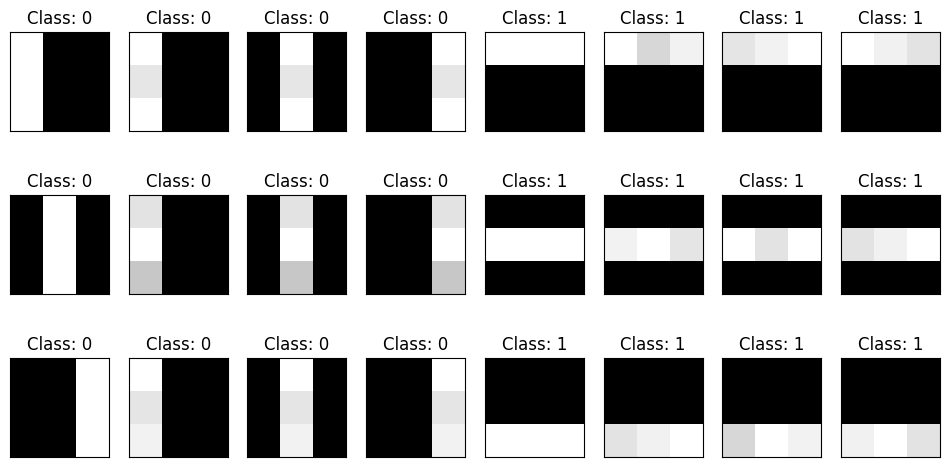

In [13]:
fig, axs = plt.subplots(3, 8, figsize=(12, 6))

iexmp = 0
for icol in range(0,8):
    for irow in range(0,3):
        axs[irow, icol].imshow(x0[:,iexmp].reshape((3, 3)).T, cmap='gray')
        axs[irow, icol].set(title=f"Class: {y[iexmp]}", xticks=[], yticks=[])
        iexmp += 1

Input matrix x0

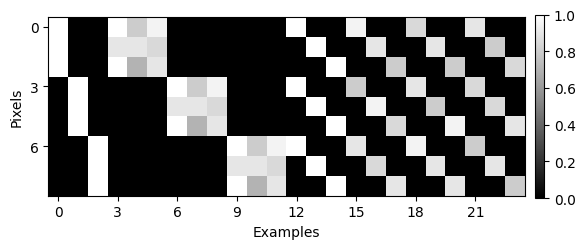

In [14]:
plt.imshow(x0, cmap='gray', vmin=0, vmax=1)
plt.xticks(ticks=np.arange(0, x0.shape[1], 3))
plt.yticks(ticks=np.arange(0, x0.shape[0], 3))
plt.colorbar(fraction=0.0185, pad=0.02)
plt.xlabel("Examples")
plt.ylabel("Pixels")
plt.show()

Vector of labels y:

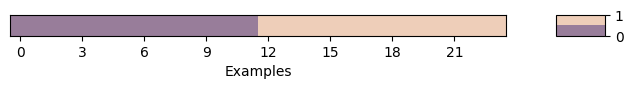

In [15]:
im = plt.imshow(y.reshape(1, -1), cmap=cmap_cl, vmin=0, vmax=1)
plt.xticks(ticks=np.arange(0, y.shape[0], 3))
plt.yticks([], [])
plt.xlabel("Examples")
add_colorbar(im)

plt.show()

One-hot-encoded labels vector:

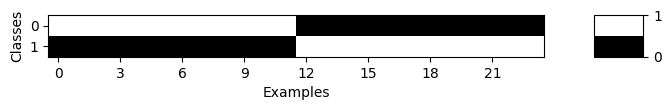

In [16]:
im = plt.imshow(y_enc, cmap=cmap_bin, vmin=0, vmax=1)
plt.xticks(ticks=np.arange(0, y_enc.shape[1], 3))
plt.yticks()
plt.xlabel("Examples")
plt.ylabel("Classes")
add_colorbar(im)

plt.show()

Initialization:

In [30]:
# Hyperparameters
n_iter = 200 # number of iterations
lr = .01 # learning rate

# Initiallize the network
n_x0_size, n_examples = x0.shape
n_l1_size = 6
W1,b1,W2,b2 = init_params(n_x0_size, n_l1_size, 7)

# Max value in w1,b1,w2,b2 for plotting the colorbar
cmap_vmax = calc_vmax(W1, b1, W2, b2)

# Pre-allocate vector for storing cross-entropy
v_xent = np.zeros(n_iter + 1)
v_acc = np.zeros(n_iter + 1)

Initialized network:

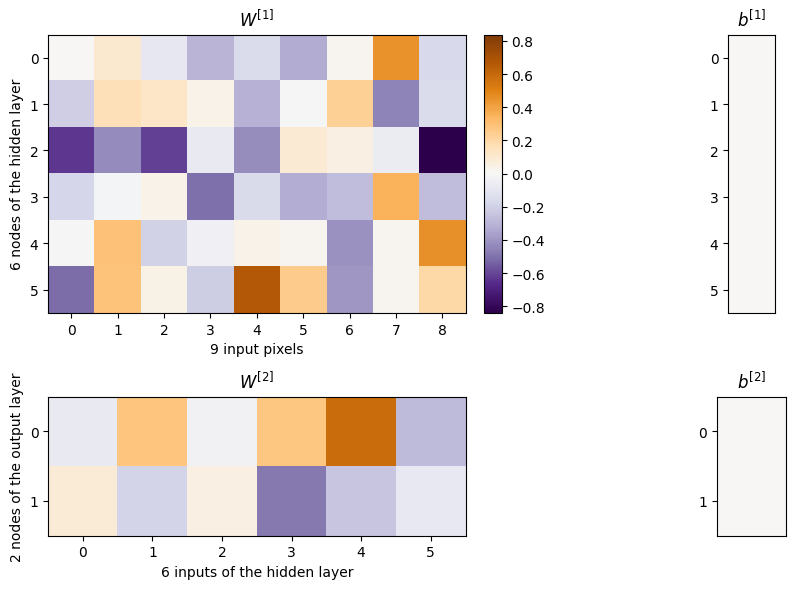

In [24]:
plot_params(W1,b1,W2,b2)

Training loop:

In [31]:
flag_acc_max = False

for iter in range(n_iter+1):

    # Forward step
    z1, A1, z2, y_hat = calc_fwd(x0, W1, b1, W2, b2)

    # Calculate cross-entropy and accuracy
    v_xent[iter] = cross_entropy(y_enc, y_hat)
    v_acc[iter] = calc_acc(y, y_hat)

    if (v_acc[iter] > MAX_ACC):
        flag_acc_max = True

    # Intermediate output
    if (iter % 20) == 0:
        print(f"Iteration: {iter}\tXent={v_xent[iter]:.4f}\tAcc={v_acc[iter]:.4f}")

    # Save intermediate plots
    if (iter % 5) == 0:
        ifname = f"{output_dir}/train_{iter:04}.png"
        save_fig(x0, W1, b1, z1, 
                 A1, W2, b2, y_hat, y,
                 v_xent, v_acc,
                 x_max = n_iter, 
                 fpath = ifname, 
                 title = f"Iteration {iter}", 
                 show = False, save=True, 
                 plot_vert = flag_acc_max)

    # Backpropagation step
    dL_dW1, dL_db1, dL_dW2, dL_db2 = calc_bck(x0, y_hat, y_enc, z1, A1, W2)

    # Update parameters
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, 
                                   dL_dW1, dL_db1, dL_dW2, dL_db2, 
                                   lr)

Iteration: 0	Xent=17.3267	Acc=0.2500
Iteration: 20	Xent=14.2200	Acc=0.6667
Iteration: 40	Xent=10.4207	Acc=0.8333
Iteration: 60	Xent=7.3794	Acc=0.8333
Iteration: 80	Xent=5.2601	Acc=1.0000
Iteration: 100	Xent=3.7983	Acc=1.0000
Iteration: 120	Xent=2.8219	Acc=1.0000
Iteration: 140	Xent=2.1705	Acc=1.0000
Iteration: 160	Xent=1.7246	Acc=1.0000
Iteration: 180	Xent=1.4107	Acc=1.0000
Iteration: 200	Xent=1.1803	Acc=1.0000


Cross entropy loss during training:

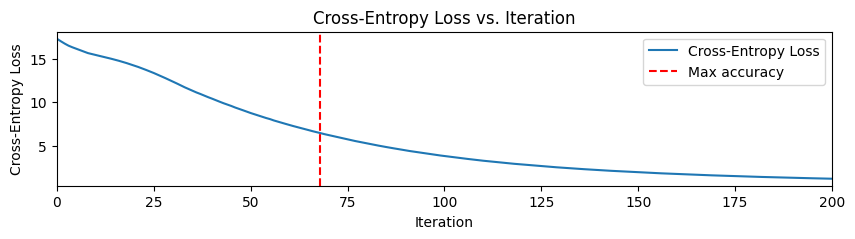

In [32]:
plt.figure(figsize=(10, 2))
plt.plot(range(v_xent.size), v_xent, label='Cross-Entropy Loss')
plt.xlim(0, 200)
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss vs. Iteration')
plt.axvline(x=np.min(np.where(v_acc > MAX_ACC)), 
            color='red', linestyle='--', label='Max accuracy')
plt.legend()
plt.show()


Training visualization:

In [33]:
# Load all png files from output_dir
png_files = [f for f in sorted(os.listdir(output_dir)) if f.endswith('.png')]

# Create a list to hold the images
images = []

# Open each file and append to the images list
for file in png_files:
    file_path = os.path.join(output_dir, file)
    images.append(Image.open(file_path))

# Save the images as an animated GIF
if IN_COLAB:
    gif_path = f"{output_dir}/train-anim.gif"
else:
    gif_path = '../figs/train-anim.gif'
    
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=100, loop=0)

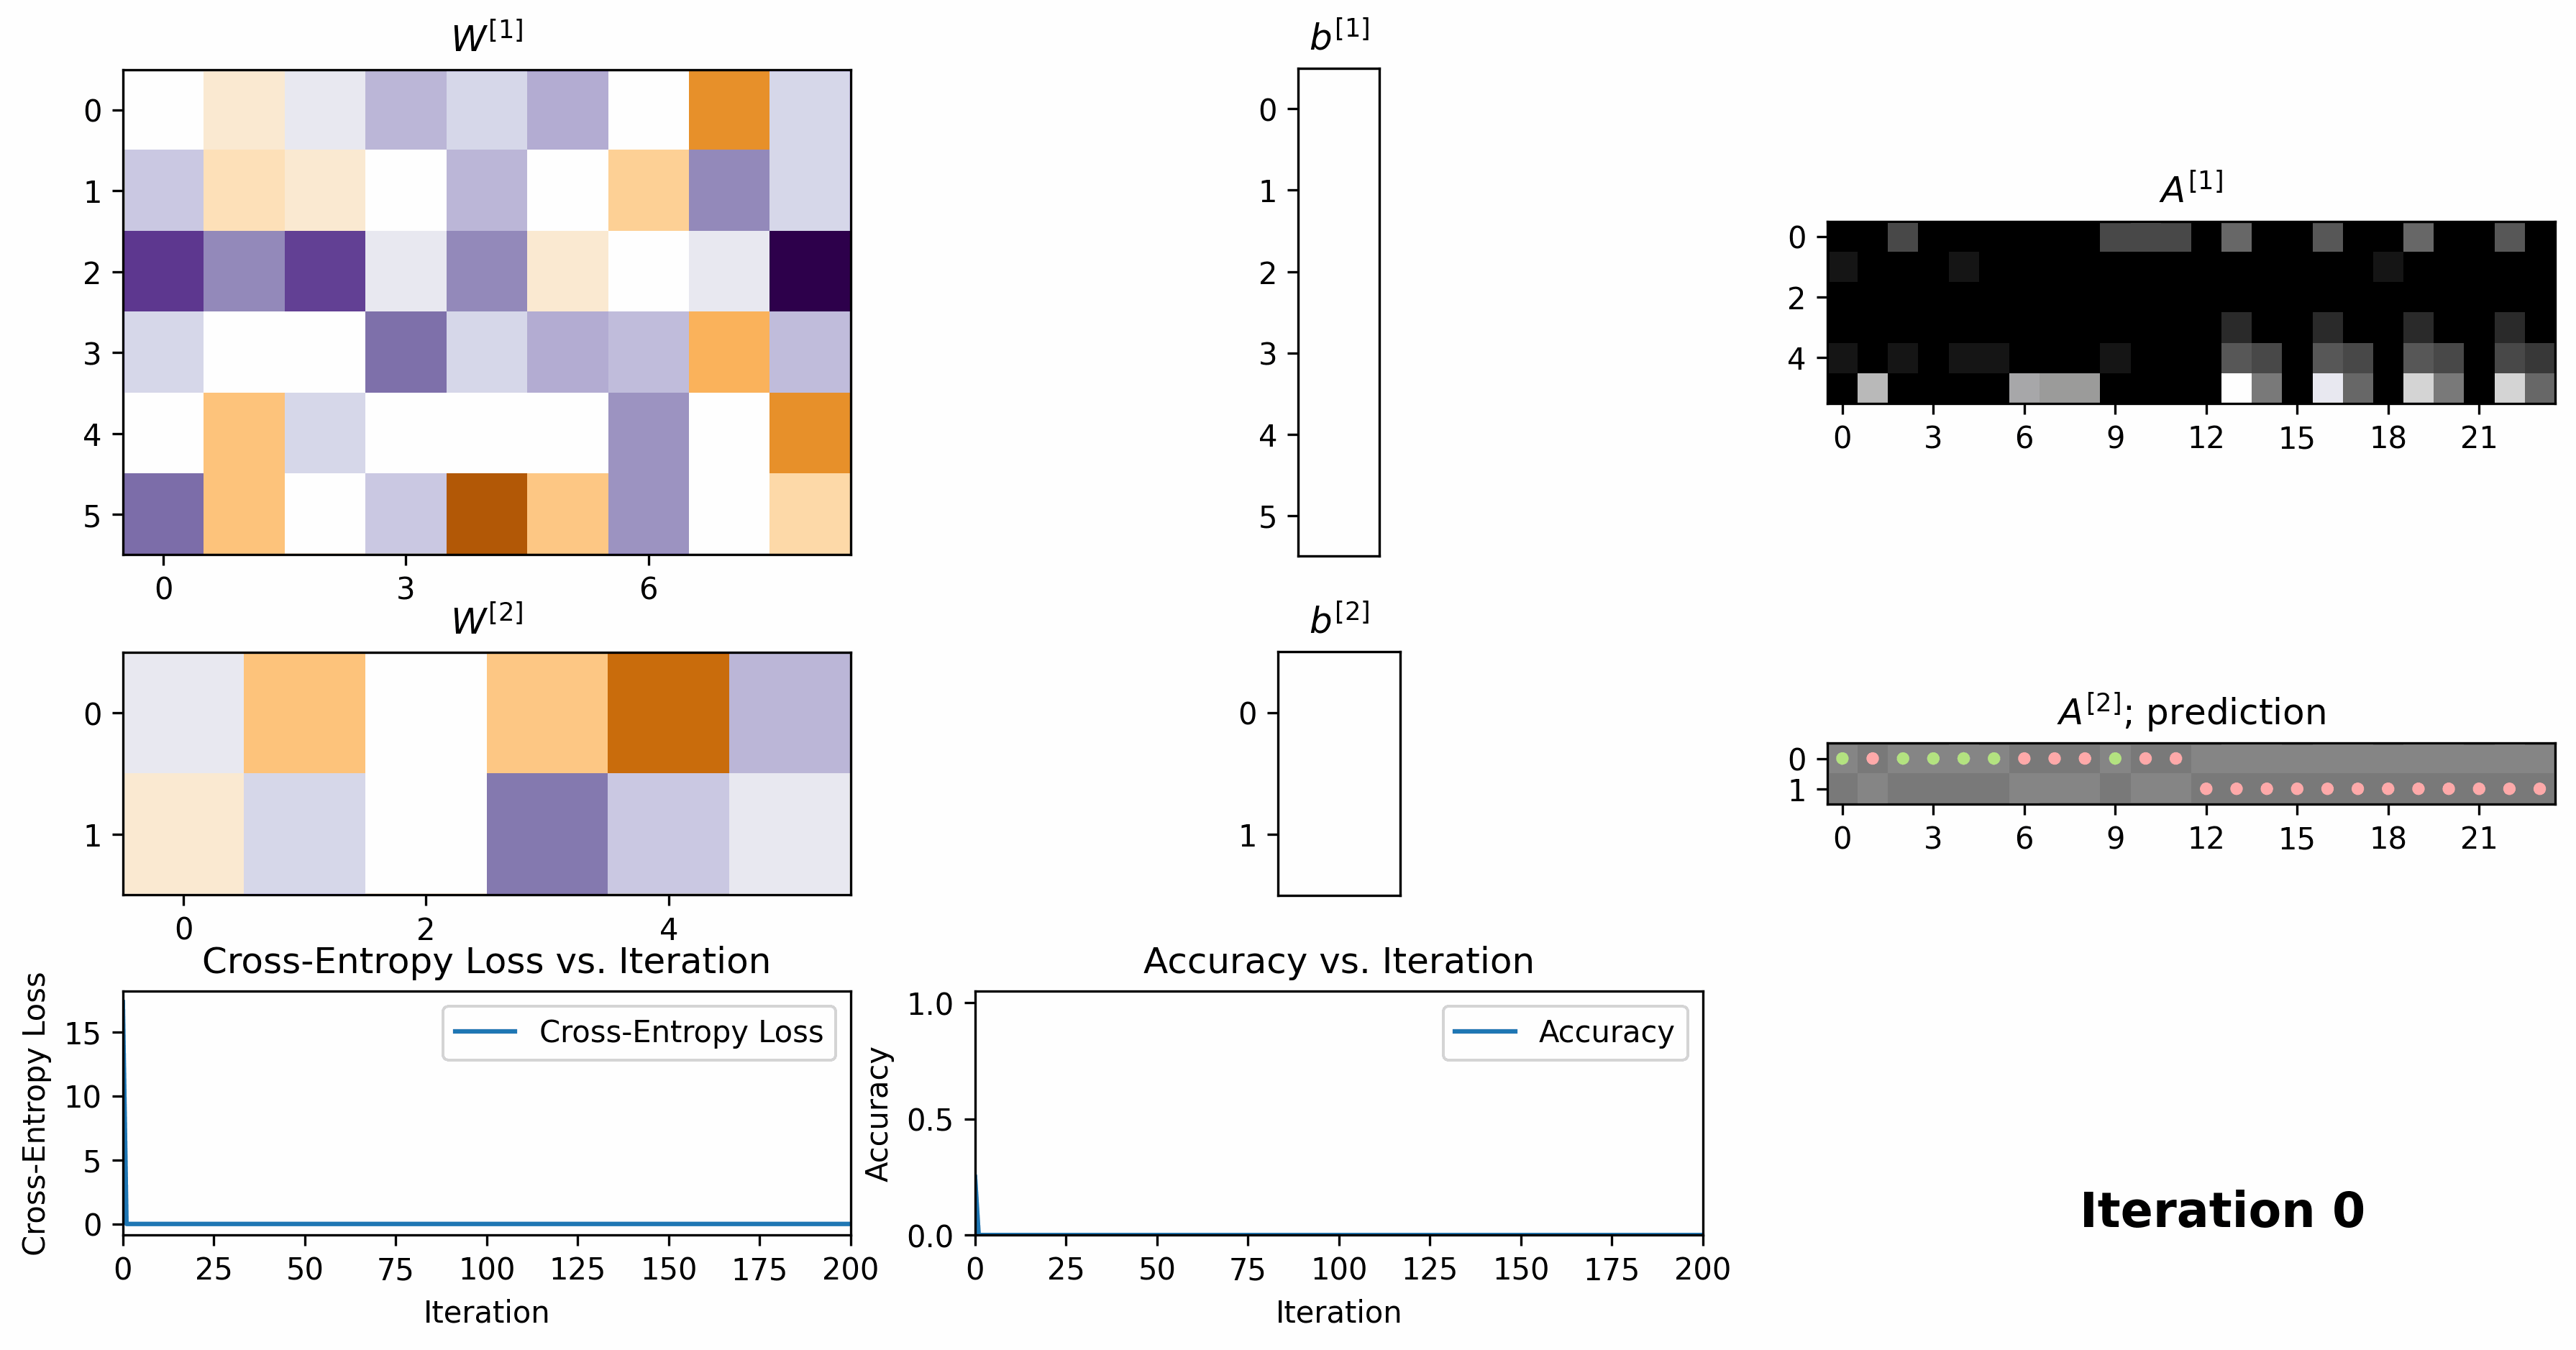

In [34]:
# Display the animated GIF in the notebook
display(IPImage(filename=gif_path))

Final state of all variables after training:

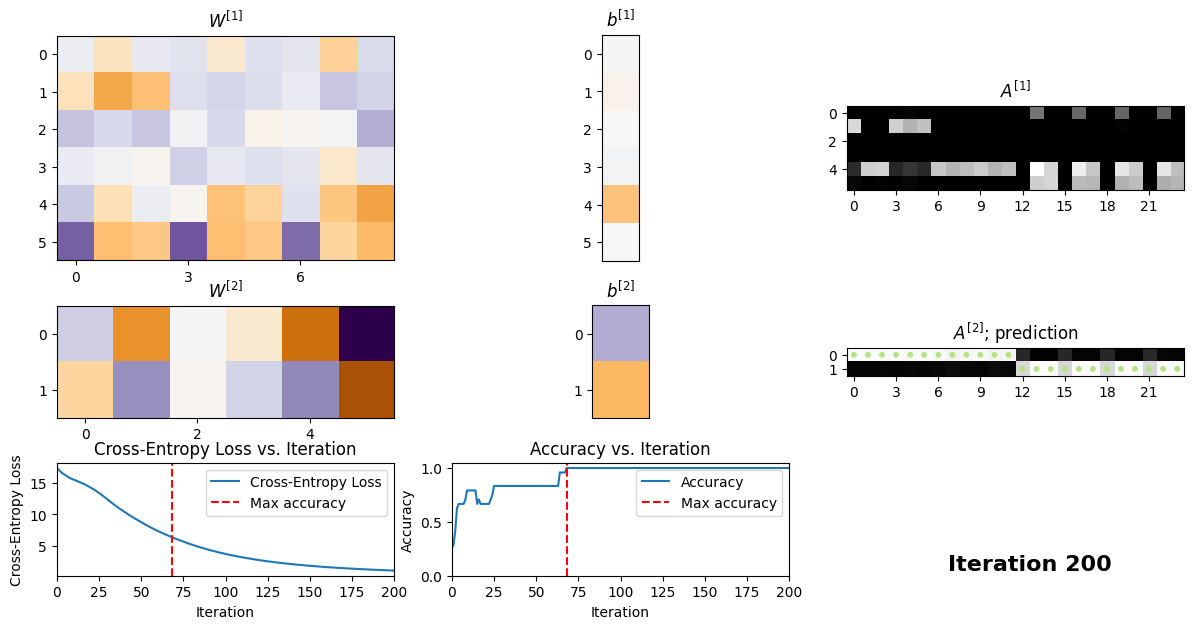

In [35]:
save_fig(x0, W1, b1, z1, A1, W2, b2, y_hat, y, v_xent, v_acc, n_iter, f"{output_dir}/train_last.png", f"Iteration {iter}", show = True, save = False, plot_vert=True)

Accuracy on the training set:

In [36]:
calc_acc(y, y_hat)

1.0

# Validation
## Set 1

In [37]:
if IN_COLAB:
    dt_val = pd.read_csv(url_valid1)
else:
    dt_val = pd.read_csv("../data/lines_3x3_valid_1.csv")

x0_val = dt_val.to_numpy()[:,0:9].T
y_val = dt_val.to_numpy(dtype=int)[:,9]
y_enc_val = one_hot_enc(y_val,2)

_,_,_, y_hat_val = calc_fwd(x0_val, W1, b1, W2, b2)

# Accuracy of on the validation set
calc_acc(y_val, y_hat_val)

1.0

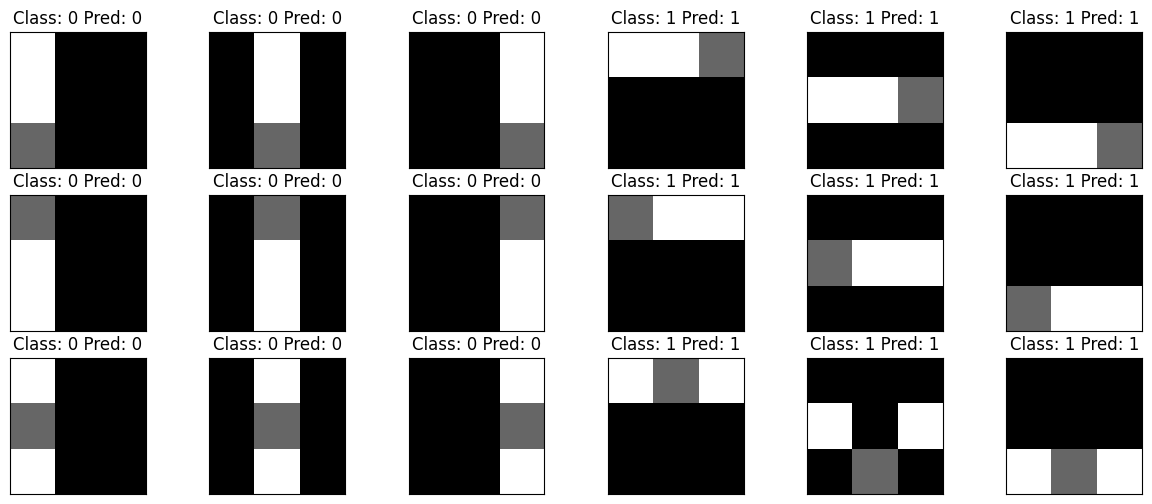

In [38]:
fig, axs = plt.subplots(3, 6, figsize=(15, 6))

iexmp = 0
for icol in range(0,6):
    for irow in range(0,3):
        axs[irow, icol].imshow(x0_val[:,iexmp].reshape((3, 3)).T, cmap='gray')
        axs[irow, icol].set(title=f"Class: {y_val[iexmp]} Pred: {np.argmax(y_hat_val, axis=0)[iexmp]}", xticks=[], yticks=[])
        iexmp += 1

## Set 2

In [39]:
if IN_COLAB:
    dt_val = pd.read_csv(url_valid2)
else:
    dt_val = pd.read_csv("../data/lines_3x3_valid_2.csv")

x0_val = dt_val.to_numpy()[:,0:9].T
y_val = dt_val.to_numpy(dtype=int)[:,9]
y_enc_val = one_hot_enc(y_val,2)

_,_,_, y_hat_val = calc_fwd(x0_val, W1, b1, W2, b2)

# Accuracy of on the validation set
calc_acc(y_val, y_hat_val)

1.0

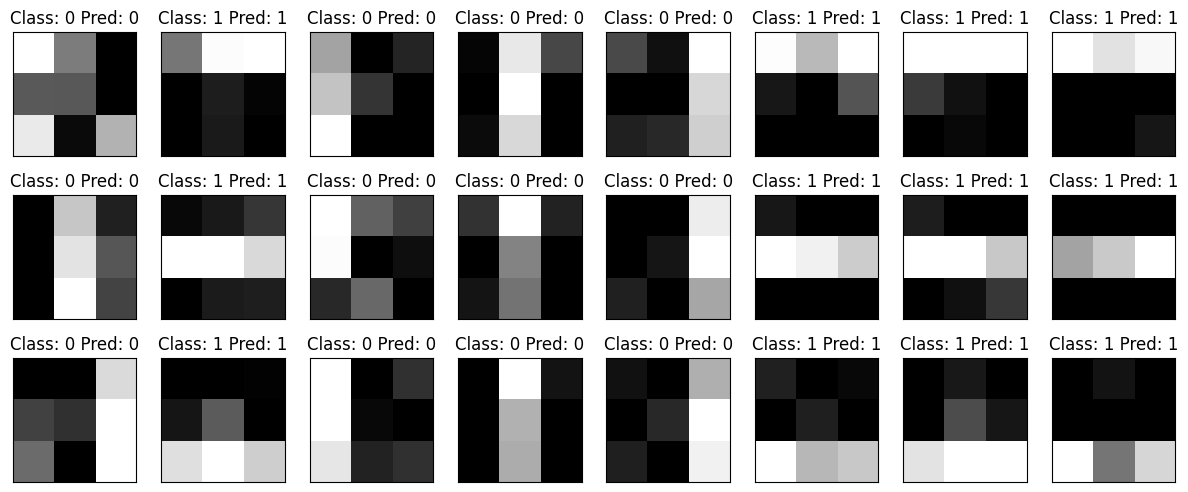

In [40]:
fig, axs = plt.subplots(3, 8, figsize=(15, 6))

iexmp = 0
for icol in range(0,8):
    for irow in range(0,3):
        axs[irow, icol].imshow(x0_val[:,iexmp].reshape((3, 3)).T, cmap='gray')
        axs[irow, icol].set(title=f"Class: {y_val[iexmp]} Pred: {np.argmax(y_hat_val, axis=0)[iexmp]}", xticks=[], yticks=[])
        iexmp += 1